In [1]:
# 핑퐁 로봇 제어 모듈 import.
from pingpongthread import PingPongThread
from time import sleep
from keyboard import is_pressed

In [2]:
# 1개 로봇을 연결하는 인스턴스 생성.
PingPong = PingPongThread(number=1, group_id=45)
# 로봇 제어 쓰레드 시작.
PingPong.start()
# 모든 로봇이 연결될 때 까지 기다림.
PingPong.wait_until_full_connect()

Found device: USB 직렬 장치(COM5)
Serial connected.Write data: DD DD 45 DD 00 00 DA 00 0B 00 00

Connected with a master robot.
Fully connected.


In [13]:
# 웹캠 열기.
PingPong.webcam_open(0)
#PingPongThread.webcam_open("http://192.168.66.1:9527/videostream
#                                   .cgi?loginuse=admin&loginpas=admin")

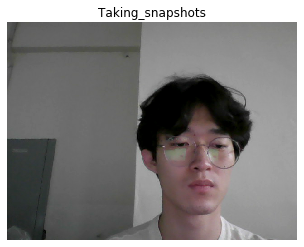

Q hit, closing...


In [5]:
# trainingData/7.no_mask 폴더 안에 '마스크 안 쓴 사진' 찍기.
PingPong.webcam_take_snapshots("trainingData/7.no_mask")

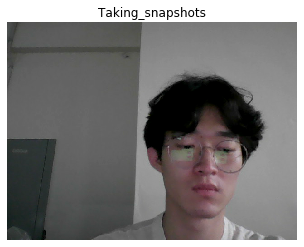

Q hit, closing...


In [6]:
# trainingData/7.with_mask 폴더 안에 '마스크 쓴 사진' 찍기.
PingPong.webcam_take_snapshots("trainingData/7.with_mask")

In [7]:
# 웹캠 닫기.
PingPong.webcam_close()

In [8]:
# '마스크 안 쓴 사진' 클래스 인스턴스, ''마스크 쓴 사진' 클래스 인스턴스 생성.
no_mask = PingPongThread.ImageClass("no_mask", "trainingData/7.no_mask")
with_mask = PingPongThread.ImageClass("with_mask", "trainingData/7.with_mask")

In [9]:
# 모델 트레이닝.(학습 시키기)
# 첫 번째 인수는 저장하는 이름, 두 번째 인수는 knn 알고리즘의 k 값,
# 세 번째 인수는 모델 모드. 네 번째 인수 이후는 클래스 인스턴스들.
model = PingPong.train_classes("model/7.mask_model.json", 5, 1, no_mask, with_mask)

Class no_mask : 43 images.
Class with_mask : 37 images.
17227776/17225924 [==============================] - 2s 0us/step
Training done.
model/7.mask_model.json saved.


In [7]:
# 센서 값 받기. 0.5초마다 한 번씩 수신.
PingPong.receive_sensor_data(1, method="periodic", period=0.5)
# 근접 센서의 디폴트 값 받기. 이 때, 근접 센서 앞에 아무것도 없도록 주의.
proxy_default = PingPong.get_default_proxy(1)

Write data: FF FF 10 00 00 C8 B8 00 0B 32 01


In [8]:
# 근접 센서를 체크하는 루프.
while not is_pressed('esc'):
    # 근접 센서 변화량.
    proxy_diff = abs(PingPong.get_current_proxy(1) - proxy_default)
    # 근접 센서 변화량이 10을 넘으면 센서값 수신을 멈추고 반복문 탈출.
    if proxy_diff > 10:
        # 센서 데이터 그만 받고 마스크 검사하기.
        PingPong.stop_sensor_data(1) 
        print("마스크를 검사할게요~.")
        sleep(3)
        break
    else:
        print("장애물이 감지되지 않았어요.")
        sleep(0.1)
        # 출력 비우기.
        PingPong.clear_output()

Write data: FF FF 10 00 00 C8 B8 00 0B 00 01
마스크를 검사할게요~.


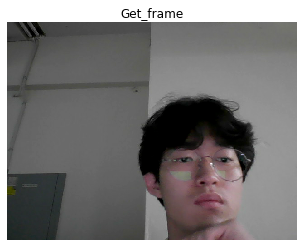

{'no_mask': 0, 'with_mask': 5}
마스크를 잘 착용하고 왔네요~. 등교를 환영합니다!
Write data: FF FF 45 00 10 00 C1 00 13 02 01 00 02 FC 7C 00 00 01 F4
Write data: FF FF 45 00 10 00 C1 00 13 02 01 00 02 03 84 00 00 01 F4


In [15]:
# 프레임을 평가하는 인스턴스 생성. 누적 프레임은 1초 동안 보관.
frames_predictor = PingPong.FramesPredictor(model=model, timer_sec=3)
# 웹캠을 이용하여 마스크 착용 여부를 예측하는 루프.
while not is_pressed('esc'):
    # 주피터 노트북 출력 비우기.(화면 초기화)
    PingPong.clear_output()
    # 현재 웹캠 프레임 가져오기.
    frame = PingPong.webcam_get_frame(window="Get_frame")
    # 현재 프레임을 평가.
    frames_prediction = frames_predictor.image_predict_and_accum(frame)
    print(frames_prediction)
    
    sleep(0.1) # 0.1초 기다리기.
    #가장 확률이 높은 클래스 이름을 max_class에 저장.
    max_class= max(frames_prediction, key=frames_prediction.get)
    if max_class == "with_mask" :
        print("마스크를 잘 착용하고 왔네요~. 등교를 환영합니다!")
        # 15RPM, 시계 반대 방향으로 1/4바퀴(90도) 회전.
        PingPong.run_motor_step(1, 15, -0.25)
        # 4초 쉼.
        sleep(4)
        # 15RPM, 시계 방향으로 1/4바퀴(90도) 회전.
        PingPong.run_motor_step(1, 15, 0.25)
        break
    else:
        print("이런… 마스크가 없네요.. 마스크를 착용하세요!")

In [16]:
# 웹캠 닫기 및 핑퐁 스레드 종료
PingPong.webcam_close()
PingPong.end()

Write data: FF FF FF FF 00 00 A8 00 0A 01
Disconnect master robot.
Serial disconnected. Sleep 3 seconds.
End thread.
